# EOF Analysis of AR days

* Multivariate EOF analysis of H, U and V

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/cEOF_hma/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### AR time series

In [4]:
## Select MERRA2 or ERA5
reanalysis = 'era5'

if reanalysis == 'era5':
    start_date = '1979-01-01'
    end_date = '2018-12-31'
    filename = 'ar_catalog_ERAI_fraction_HASIAsubregions.nc'
## if MERRA2
else:
    start_date = '1980-01-01'
    end_date = '2017-12-31'
    filename = 'ar_catalog_fraction_HASIAsubregions.nc'
    
f1 = path_to_data + 'CH1_generated_data/' + filename
ds = xr.open_dataset(f1)
# Set dates
ds = ds.sel(time=slice(start_date, end_date))
## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()

,R01,R02,R03,ar,location
time,,,,,
1979-01-01,0.000000,0.0,0.0,0,NaN
1979-01-02,0.000000,0.0,0.0,0,NaN
1979-01-03,0.005102,0.0,0.0,0,NaN
1979-01-04,0.000000,0.0,0.0,0,NaN
1979-01-05,0.000000,0.0,0.0,0,NaN


### Import reanalysis

#### ERA5

In [5]:
## Set variable names (for saving data/figs)
var_names = 'HUV500'
eofmode = 's' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance

# Select lat/lon grid 
# HASIA Domain
lonmin = 0
lonmax = 120
latmin = 0
latmax =  50

lev = 500.

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=lev)

# open HUV anomaly data
filepath_pattern = path_to_data + 'ERA5/huvq/anomalies/daily_filtered_anomalies_huvq_*.nc'
    
    
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')

# Create new dataset to rename lat lon
ds = xr.Dataset({'H': (['time', 'lat', 'lon'], f2['z'].values),
                 'U': (['time', 'lat', 'lon'], f2['u'].values),
                 'V': (['time', 'lat', 'lon'], f2['v'].values)},
                      coords={'time': (['time'], f2.time.values),
                              'lat': (['lat'], f2.latitude.values),
                              'lon': (['lon'], f2.longitude.values)})

ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds size in GB 8.54



#### MERRA2

In [6]:
# ## Set variable names (for saving data/figs)
# var_names = 'HUV500'
# eofmode = 't' # s or t
# dispmat = 'cor' # dispersion matrix type correlation/covariance

# # Select lat/lon grid 
# # HASIA Domain
# lonmin = 0
# lonmax = 120
# latmin = 0
# latmax =  50


# # for figure names for testing different configurations
# fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat

# def preprocess(ds):
#     '''keep only selected lats and lons'''
#     return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

# ### MERRA2 DATA ###
# # open H data
# filepath_pattern = path_to_data + 'MERRA2/anomalies/H500/daily_*.nc'

# ds_h = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, concat_dim='time', combine='by_coords')
# print('ds size in GB {:0.2f}\n'.format(ds_h.nbytes / 1e9))

# ## open UV data
# filepath_pattern = path_to_data + 'MERRA2/anomalies/UV500/daily_*.nc'
# ds_uv = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
# print('ds size in GB {:0.2f}\n'.format(ds_uv.nbytes / 1e9))

# ## combine H and UV data into 1 ds object
# ds = xr.merge([ds_h, ds_uv.U, ds_uv.V])
# # merra

In [7]:
# Add AR time series to merra; set as coordinate variables
ds['ar'] = ('time', df.ar)
ds = ds.set_coords('ar')

ds['location'] = ('time', df.location)
ds = ds.set_coords('location')

# print dataset
print(ds)

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 241, time: 14610)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    location  (time) object nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    H         (time, lat, lon) float64 -2.615e+03 -2.655e+03 ... 223.9 222.9
    U         (time, lat, lon) float64 1.489 1.765 1.789 ... 6.08 5.374 5.342
    V         (time, lat, lon) float64 -9.859 -9.301 -8.792 ... -1.137 -1.631


### Data Subset Selection

In [8]:
# Trim date range
if reanalysis == 'era5':
    start_date = '1979-12-01'
    end_date = '2018-02-28'
    ys = 1979
    ye = 2018
else:
    start_date = '1980-12-01'
    end_date = '2017-02-28'
    ys = 1980
    ye = 2017
    
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select DJF months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 2)
ds = ds.sel(time=idx)

# # Select AR days JUST IN R01
# idx = (ds.ar >= 1) & (ds.location == 'R01')
# Select AR days in all subregions
idx = (ds.ar >= 1)
ds_ar = ds.sel(time=idx)

# print results
print(ds_ar)

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 241, time: 371)
Coordinates:
  * time      (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location  (time) object 'R03' 'R01' 'R01' 'R01' ... 'R03' 'R02' 'R01' 'R01'
Data variables:
    H         (time, lat, lon) float64 1.439e+03 1.405e+03 ... -2.202 0.2929
    U         (time, lat, lon) float64 12.56 13.75 14.45 ... 1.072 1.248 0.8793
    V         (time, lat, lon) float64 -5.224 -5.615 -5.994 ... -0.2258 0.272


In [9]:
# Count number of independent AR events

years = np.arange(ys, ye) 
nyrs = len(years)
total_events = 0
for k in range(nyrs-1):    
    # Extract single DJF season
    date1 = "{}-12-01".format(years[k])
    date2 = "{}-02-28".format(years[k+1])
    x = ds.ar.sel(time=slice(date1,date2)).values
    # Count AR events in that season
    tags, tmp = persistence(x)
    # Add to running event count
    total_events += tmp

print("Number of independent AR events: ", total_events)

Number of independent AR events:  199


## Preprocessing

### Reshape, center, and standardize data matrix

In [10]:
%%time
# Load ds_ar dataset into memory
ds_ar = ds_ar.load()


CPU times: user 30 µs, sys: 61 µs, total: 91 µs
Wall time: 103 µs


In [11]:
## Create list of variable arrays
var1 = ds_ar.U
var2 = ds_ar.V
var3 = ds_ar.H

var_list = [var1, var2, var3]

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)


(371, 101, 241)
(371, 101, 241)
(371, 101, 241)


In [12]:
%%time
# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Flatten data to [time x space]
var_list = flatten_array(var_list)

## Center data
var_list = center_data(var_list)

## Standardize Arrays by removing the mean and dividing by the standard deviation of the columns
## For multivariate, place into single flattened array
Xs = standardize_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)

EOF mode:  s
Dispersion Matrix:  cor
(371, 73023)
Column means:  0.0
Column std:  1.0
CPU times: user 1.6 s, sys: 987 ms, total: 2.59 s
Wall time: 2.73 s


## EOF Analysis

In [13]:
%%time

# Compute eigenvalues & eigenvectors
R, evals, evecs = calc_eigs(z=Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

Eigenvalues:  (371,)
[ 5.29630815e+01  3.84850916e+01  3.12010015e+01  2.16587934e+01
  1.78183794e+01  1.68328354e+01  1.30523234e+01  1.20473566e+01
  1.11734483e+01  9.91132123e+00  8.65949664e+00  7.56327647e+00
  6.80331143e+00  6.36899749e+00  5.75233822e+00  5.38026314e+00
  4.78812976e+00  4.36395975e+00  4.11921790e+00  3.77035322e+00
  3.39559376e+00  3.29942382e+00  3.01473807e+00  2.94760173e+00
  2.61072600e+00  2.59047188e+00  2.34815837e+00  2.28384347e+00
  2.23977415e+00  2.02088747e+00  2.00447365e+00  1.83429440e+00
  1.77786154e+00  1.67425701e+00  1.57344791e+00  1.51712187e+00
  1.38665366e+00  1.32236774e+00  1.28395027e+00  1.24710469e+00
  1.18816707e+00  1.15398790e+00  1.07709921e+00  1.04410040e+00
  9.90678779e-01  9.57257158e-01  9.08144822e-01  8.65631916e-01
  8.68738247e-01  8.16953404e-01  7.91477361e-01  7.55583953e-01
  7.29907375e-01  7.08537281e-01  6.75503905e-01  6.63086535e-01
  6.52578668e-01  6.13799312e-01  6.03432376e-01  5.66691633e-01
  5.

Text(0.5, 1.0, 'Dispersion Matrix (cor)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


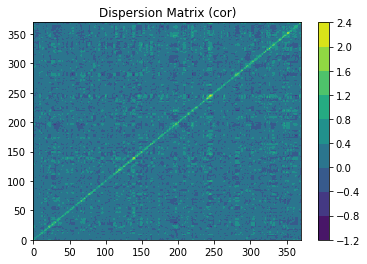

In [14]:
plt.contourf(R)
plt.colorbar()
title = 'Dispersion Matrix (' + dispmat + ')'
plt.title(title)

### Explained Variance

In [15]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 20 EOFs:
75.19% 

Cumulative variance explained by the first 4 EOFs:
33.06% 

1 	 14.28%
2 	 10.37%
3 	 8.41%
4 	 5.84%


### North Test

In [16]:
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[15.707 11.413  9.253  6.423  5.284  4.992]
[14.276 10.373  8.41   5.838  4.803  4.537]
[12.844  9.333  7.567  5.253  4.321  4.082]


### Fig 2: Variance

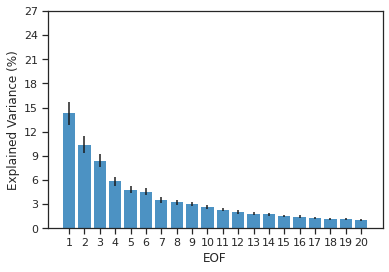

In [17]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,30,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs + 'exp_variance_' + fname_id + '.png'
plt.savefig(filepath, dpi=300)

# show
plt.show()

### Loadings

In [18]:
neofs = 19
loads = loadings(evals, evecs, neofs)

print(loads.shape)
print(np.round(loads,3))

(371, 19)
[[ 0.472 -0.086 -0.168 ...  0.081  0.142  0.032]
 [ 0.439  0.178 -0.165 ...  0.029  0.028  0.082]
 [ 0.066 -0.333  0.138 ...  0.299  0.076 -0.06 ]
 ...
 [-0.45   0.579  0.029 ...  0.257 -0.265  0.121]
 [ 0.112  0.261 -0.585 ... -0.025 -0.062 -0.146]
 [-0.064  0.15   0.023 ... -0.063  0.036 -0.155]]


### Save EOFs

In [19]:
# Save eigenvalues, eigenvectors, and loadings

neofs = 4   # number of EOFs to save (evecs, loadings3)

outfile = path_to_out + 'eigenvalues_'+ fname_id + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = path_to_out + 'eigenvectors_'+ fname_id + '.txt'
np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

outfile = path_to_out + 'loadings_'+ fname_id + '.txt'
np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### PCs and EOFs

In [24]:
print(evecs[0:19, :].shape)
print(Xs.shape)
# evecs[:, 0:neofs].T, z
print(evecs[:,0:19].T.shape)

(19, 371)
(371, 73023)
(19, 371)


In [25]:
# Calculate EOFs
neofs = 19
pcs = calc_eofs(Xs, evecs, neofs, mode=eofmode)

# Split pcs into separate arrays for each variable
ntim, nlat, nlon = var2.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
pcmodes = var_list
for i in np.arange(len(var_list)):
    tmp = pcs[:,i*npts:(i+1)*npts]
    pcmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))

### Fig 3: Spatial Modes

In [26]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting extratropics
lons = var2.lon.data
lats = var2.lat.data
udat = pcmodes[0][0:neofs,:,:]
vdat = pcmodes[1][0:neofs,:,:]
data = pcmodes[2][0:neofs,:,:]

print(np.nanmin(data), np.nanmax(data))

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
pc_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    pc_label.append("PC{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

-14.17070795545091 16.616221199756204


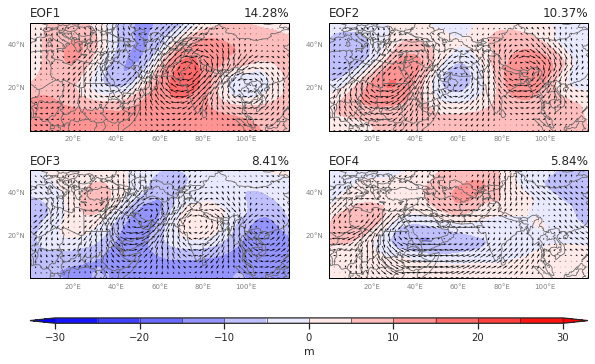

In [27]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'eofs_'+ fname_id + '.png'
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

#newcmap = cmocean.tools.crop_by_percent(cmo.matter, 15, which='max', N=None)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
#     ax = draw_basemap(ax, extent=None, xticks=dx, yticks=dy)
    
    # Add contour fill plot for extratropics
    clevs = np.arange(-30,31,5)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    # add vectors for extratropics
    ax.quiver(lons, lats, udat[k,:,:], vdat[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=20) 
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('m', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

In [29]:
loads.shape

(371, 19)

/home/nash/DATA/repositories/AR_types/figs/cEOF_hma/pc_HUV500s0120050cor.png


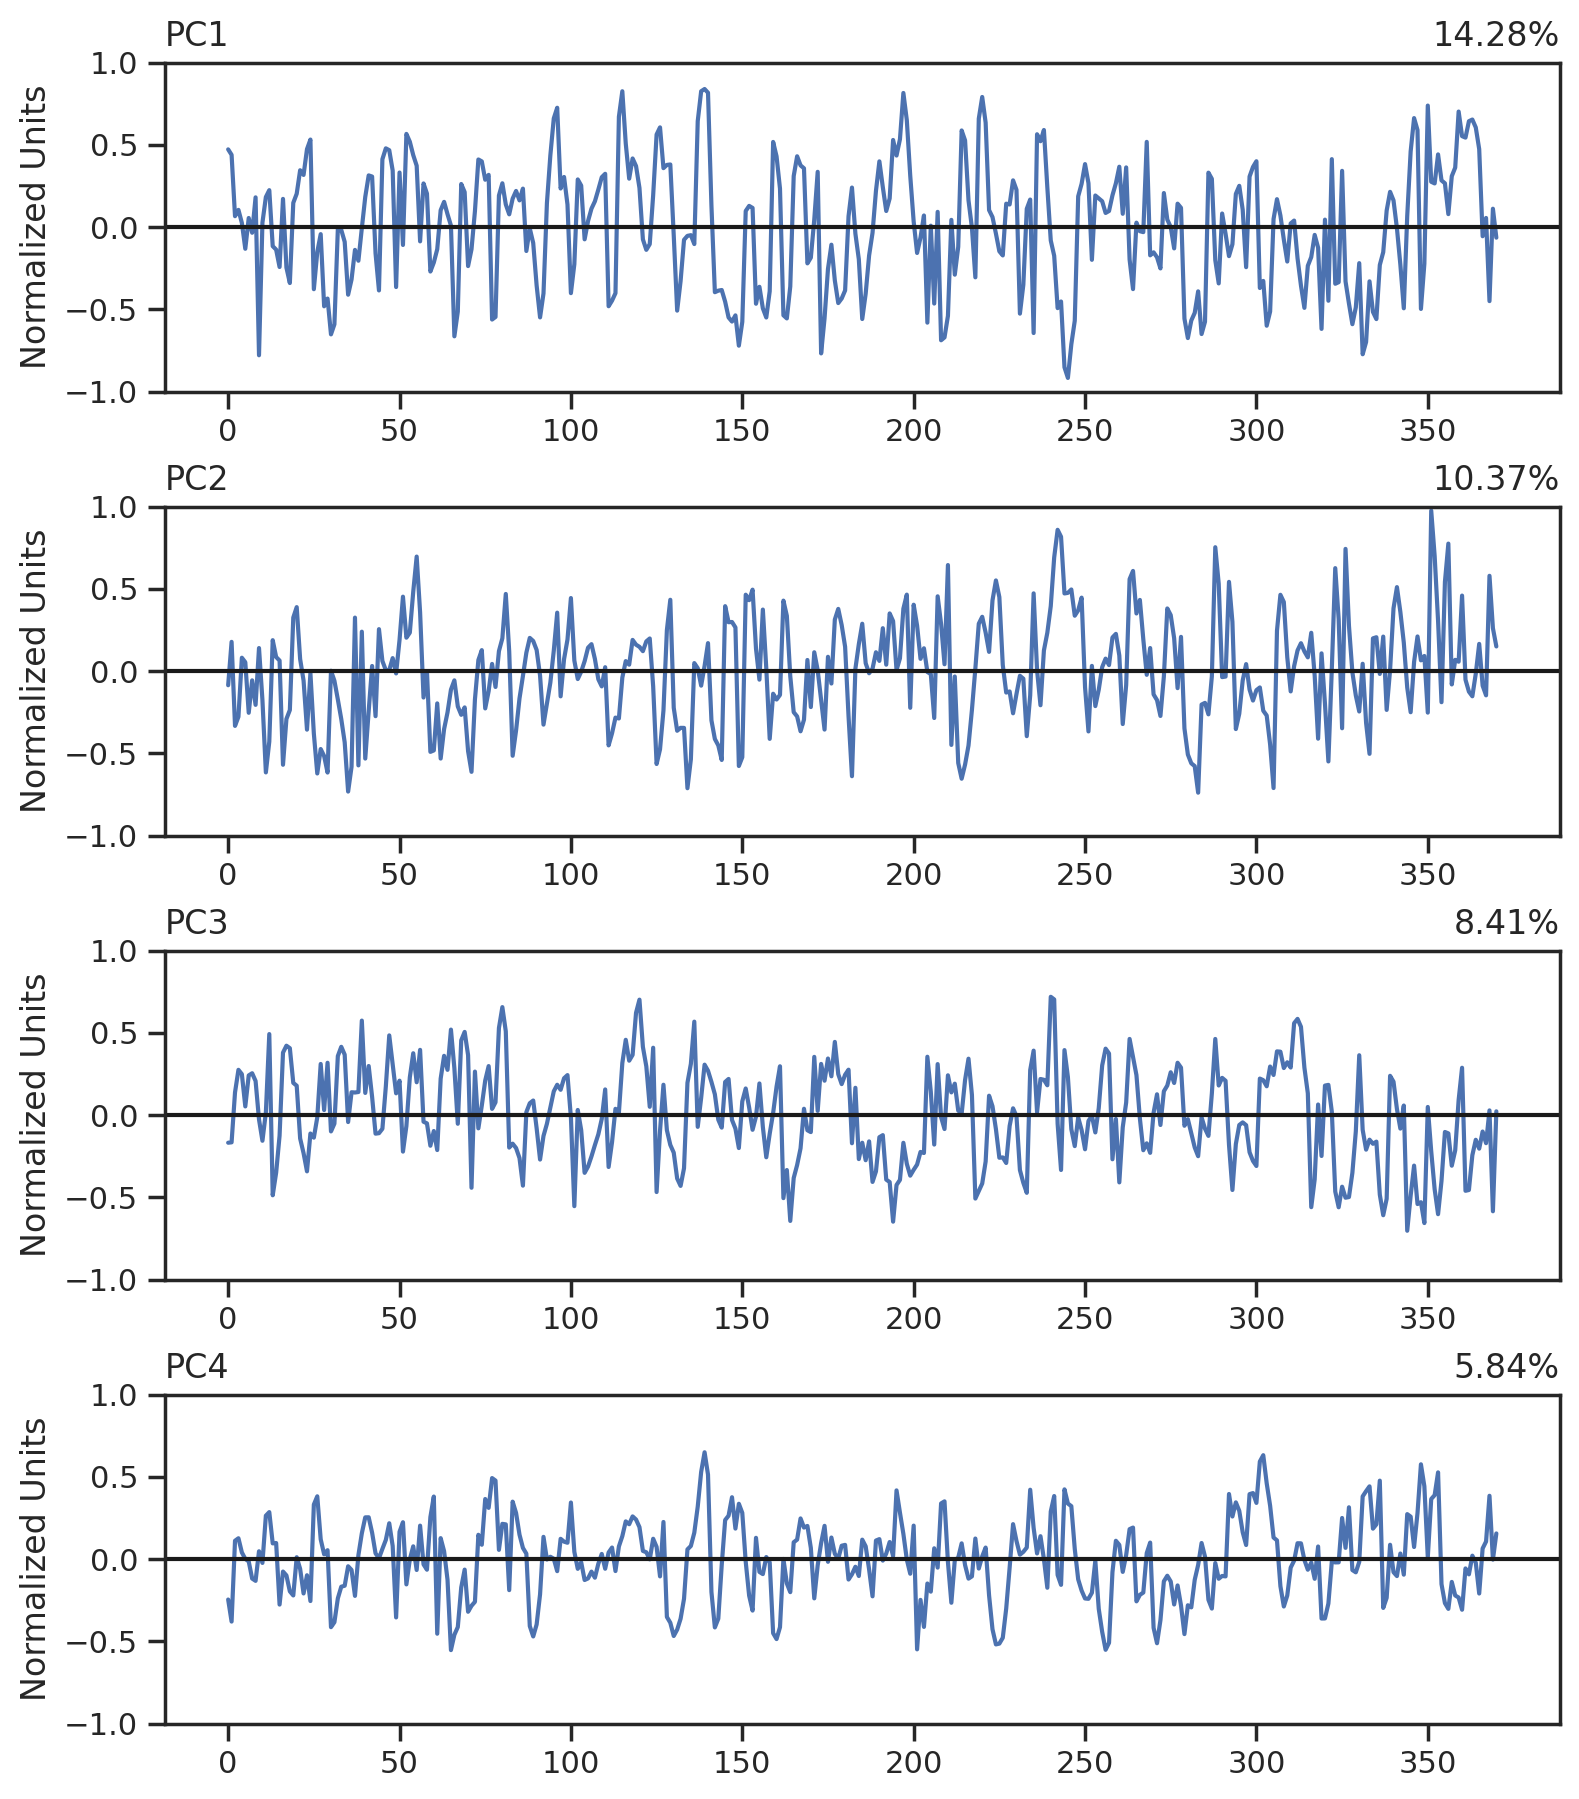

<Figure size 1800x2200 with 0 Axes>

In [30]:
fig = plt.figure(figsize=(9,11))
fig.dpi = 200
fname = path_to_figs + 'pc_'+ fname_id
fmt = 'png'
results = loads[:,:4]

X, nplots = results.shape
x = np.arange(len(results))

for i in np.arange(nplots):
    ax = plt.subplot(4, 1, i+1)
    ax.plot(x, results[:,i], '-')
    ax.axhline(0, color='k')
    ax.set_ylim(-1, 1)
    ax.set_ylabel('Normalized Units')
    # subtitles
    ax.set_title(pc_label[i], loc='left', fontsize=12)
    ax.set_title(var_label[i], loc='right', fontsize=12)

plt.subplots_adjust(hspace=0.35, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### K-means clustering

In [ ]:
# Determine optimal K

# maximum number of clusters (number of iterations)
kmax =15
# number of eofs
neofs = 4
# input data
xdata = loads[:,0:neofs]

# Elbow plot
outfile = path_to_figs + 'elbow'+ fname_id
plot_optimal_k(xdata, kmax, filename=outfile)


In [ ]:
# Count number of days in each cluster
klabels, counts = np.unique(ar_cat, return_counts=True)

# Save counts to txt file
res = np.column_stack((klabels,counts))
headstr = 'AR_TYPE, COUNT'
outfile = path_to_out + fname_id + 'k_counts.txt'
np.savetxt(outfile, res, delimiter=',', fmt='%d', header=headstr)



In [ ]:
# Cluster centroids (nclust x neofs)
centroids = kmeans.cluster_centers_

# Save centroids to txt file
res = np.column_stack((klabels,centroids))
headstr = "AR_TYPE, EOF1, EOF2, EOF3, EOF4"
outfile = path_to_out + fname_id + 'centroids.txt'
np.savetxt(outfile, res, delimiter=',', fmt='%s', header=headstr)


### Save AR Category Labels

In [ ]:
## Save AR location, loadings (EOF1-4), and category label (AR days only)

# Vector of AR dates
dates_arDays = era_ar.time.values

# Create new dataframe
data = {'LOC':era_ar.location.values,
        'EOF1':loads[:,0],
        'EOF2':loads[:,1],
        'EOF3':loads[:,2],
        'EOF4':loads[:,3],
        'AR_CAT':ar_cat}
df_out = pd.DataFrame(data, index=dates_arDays)
print(df_out)

# Export dataframe as csv
outfile = path_to_out + fname_id + 'hma_AR-types-loadings.csv'
df_out.to_csv(outfile)


In [ ]:
## Save time series of all DJF days with AR types

# Arrays with ALL DJF days
dates_allDays = era.time.values
ar_cat_allDays = np.zeros(len(dates_allDays), dtype=int)

# Loop over ar days and match to ar_full 
for i, date in enumerate(dates_arDays):
    idx = np.where(dates_allDays == date)
    ar_cat_allDays[idx] = ar_cat[i]  

# Create dataframe
data = {'AR_CAT':ar_cat_allDays}
df_out = pd.DataFrame(data, index=dates_allDays)
print(df_out)

outfile = path_to_out + fname_id + 'hma_AR-types-djf.csv'
df_out.to_csv(outfile)
